In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt


In [2]:
data_dir = "../raw_data/images_png/"


In [3]:
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 32
IMAGE_SIZE = (64, 376)
SHUFLE_VALUE = True
RANDOM_SEED = 42
TEST_SIZE_PART = 1

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=VALIDATION_SPLIT,
  subset="training",
  seed=RANDOM_SEED,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  color_mode = "grayscale",
  shuffle = SHUFLE_VALUE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=VALIDATION_SPLIT,
  subset="validation",
  seed=RANDOM_SEED,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  color_mode = "grayscale",
  shuffle = SHUFLE_VALUE)


Found 38044 files belonging to 34 classes.
Using 26631 files for training.
Found 38044 files belonging to 34 classes.
Using 11413 files for validation.


In [4]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((TEST_SIZE_PART*val_batches) // 3)
val_ds = val_ds.skip((TEST_SIZE_PART*val_batches) // 3)


In [5]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)


['banswa', 'barswa', 'calqua', 'cangoo', 'caster1', 'comloo', 'comrav', 'comred', 'comter', 'eargre', 'eucdov', 'eursta', 'gadwal', 'gnwtea', 'goleag', 'greegr', 'hergul', 'horlar', 'houspa', 'mallar3', 'merlin', 'norsho', 'osprey', 'pecsan', 'perfal', 'redcro', 'ribgul', 'rinduc', 'rocpig', 'rudduc', 'sheowl', 'silence', 'snobun', 'tunswa']


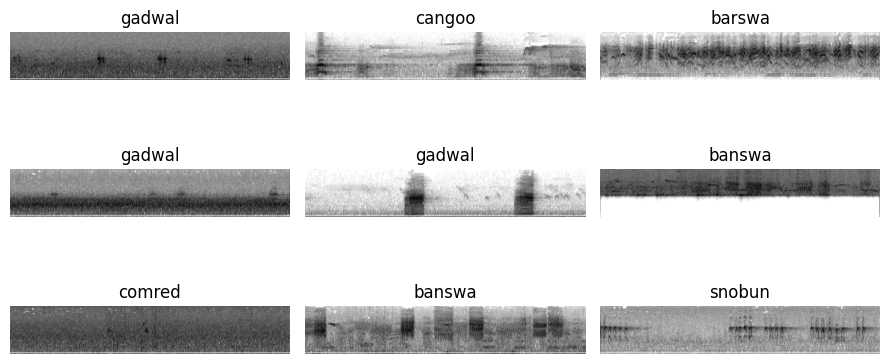

In [6]:
plt.figure(figsize=(9, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.tight_layout()


In [7]:

model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(64, 376, 1)),
  layers.Conv2D(64, (2,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, (2,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.04),
  layers.Conv2D(64, (3,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(1568, activation='relu'),
  layers.Dense(500, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [9]:
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 376, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 64, 376, 64)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 188, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 188, 64)       24640     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 94, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 94, 64)        0

In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

# We will store the logs in a folder (one folder per fit)
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [48]:
from birdsong.utils import create_folder_if_not_exists

# Create a callback that saves the model's weights
checkpoint_folder_path = "../models_checkpoints/raman_model_test_baseline/"
create_folder_if_not_exists(checkpoint_folder_path)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = os.path.join(checkpoint_folder_path,"cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

PATIENCE = 6

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=PATIENCE)



# Calculate the number of batches per epoch
import math
n_batches = len(train_ds) / BATCH_SIZE
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*n_batches)


In [12]:
epochs=30

# Save the weights using the `checkpoint_path` format
model_1.save_weights(checkpoint_path.format(epoch=0))

history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es,tensorboard_callback,cp_callback]
)


Epoch 1/30


/Users/ramansheshka/.pyenv/versions/3.10.6/envs/birdsong/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


833/833 [==============================] - ETA: 0s - loss: 2.6067 - accuracy: 0.2724
Epoch 1: saving model to ../models_checkpoints/raman_model_test_baseline/cp-0001.ckpt
833/833 [==============================] - 263s 315ms/step - loss: 2.6067 - accuracy: 0.2724 - val_loss: 1.8939 - val_accuracy: 0.4748
Epoch 2/30
833/833 [==============================] - ETA: 0s - loss: 1.6958 - accuracy: 0.5262
Epoch 2: saving model to ../models_checkpoints/raman_model_test_baseline/cp-0002.ckpt
833/833 [==============================] - 269s 323ms/step - loss: 1.6958 - accuracy: 0.5262 - val_loss: 1.5641 - val_accuracy: 0.5641
Epoch 3/30
833/833 [==============================] - ETA: 0s - loss: 1.3098 - accuracy: 0.6305
Epoch 3: saving model to ../models_checkpoints/raman_model_test_baseline/cp-0003.ckpt
833/833 [==============================] - 277s 333ms/step - loss: 1.3098 - accuracy: 0.6305 - val_loss: 1.3161 - val_accuracy: 0.6376
Epoch 4/30
833/833 [==============================] - ETA: 0

In [13]:
SAVE_FORMAT='h5'
model_1.save('../models_checkpoints/raman_dump_baseline', save_format=SAVE_FORMAT)


/Users/ramansheshka/.pyenv/versions/3.10.6/envs/birdsong/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
def plot_history(history, metric_label, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name

    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    #ax1.set_ylim(min(history.history['loss']) * 0.9,
    #             max(history.history['loss']) * 1,)
    ax1.set_title('loss')
    ax1.legend()
    ax1.set_xlabel('epochs')
    ax1.spines.right.set_visible(False)
    ax1.spines.top.set_visible(False)

    ax2.plot(history.history[metric_label], label='train ' + metric_label  + exp_name)
    ax2.plot(history.history['val_'+metric_label], label='val ' + metric_label  + exp_name)
    #ax2.set_ylim(min(history.history[metric_label]) * 0.9,
    #             max(history.history[metric_label]) * 1)
    ax2.set_title(metric_label.capitalize())
    ax2.legend()
    ax2.set_xlabel('epochs')
    ax2.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    return (ax1, ax2)


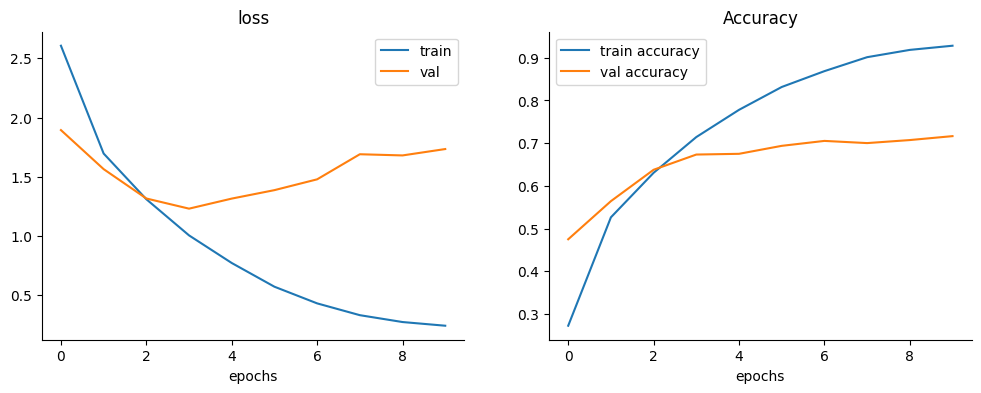

In [15]:
plot_history(history, 'accuracy', title='', axs=None, exp_name="")
plt.show()


In [32]:

%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 73529), started 2:03:10 ago. (Use '!kill 73529' to kill it.)

In [17]:
predictions = model_1.predict(test_ds)


119/119 [==============================] - 10s 79ms/step


In [18]:
model_1.predict(test_ds)


  1/119 [..............................] - ETA: 15s

119/119 [==============================] - 10s 80ms/step


array([[7.4906659e-04, 1.7669828e-08, 4.2668384e-04, ..., 5.9630144e-01,
        1.2682810e-03, 2.8420587e-03],
       [2.4267475e-08, 1.4269651e-08, 1.7827209e-09, ..., 8.3599918e-09,
        9.1054214e-10, 2.6194914e-14],
       [5.0357062e-16, 3.3032787e-08, 1.0000000e+00, ..., 1.7729675e-15,
        2.6763665e-09, 5.0173279e-27],
       ...,
       [2.6511049e-07, 3.0440666e-09, 1.3624943e-06, ..., 6.6189571e-08,
        5.3341290e-07, 3.8247995e-16],
       [9.8225064e-21, 6.3167170e-32, 1.5812916e-27, ..., 4.3619723e-28,
        4.3774168e-24, 1.4772424e-18],
       [1.0996303e-16, 3.7223460e-11, 1.2598156e-10, ..., 4.3437861e-11,
        8.8534247e-13, 7.4674797e-18]], dtype=float32)

In [30]:
(n_rows, n_columns) = predictions.shape
score_pred = []
for n in range(n_rows):
    score_pred.append([np.argmax(predictions[n]),
                       class_names[np.argmax(predictions[n])],"this song most likely belongs to {} with a {:.2f} percent confidence."\
                       .format(class_names[np.argmax(predictions[n])], 100 * np.max(predictions[n]))])

df = pd.DataFrame(score_pred, columns=["prediction", "class", "description"])

#print(
#    "This image most likely belongs to {} with a {:.2f} percent confidence."
#    .format(class_names[np.argmax(score)], 100 * np.max(score)))


In [31]:
df


,prediction,class,description
0,6,comrav,this song most likely belongs to comrav with a...
1,2,calqua,this song most likely belongs to calqua with a...
2,31,silence,this song most likely belongs to silence with ...
3,25,redcro,this song most likely belongs to redcro with a...
4,29,rudduc,this song most likely belongs to rudduc with a...
...,...,...,...
3803,6,comrav,this song most likely belongs to comrav with a...
3804,22,osprey,this song most likely belongs to osprey with a...
3805,25,redcro,this song most likely belongs to redcro with a...
3806,24,perfal,this song most likely belongs to perfal with a...


In [24]:
(loss_evaluate,accuracy_evaluate) =  model_1.evaluate(test_ds)


119/119 [==============================] - 9s 75ms/step - loss: 1.6625 - accuracy: 0.7222


In [29]:
display(f"resulting evaluation loss = {np.round(loss_evaluate, decimals=3)}, accuracy = {np.round(accuracy_evaluate, decimals=3)}")


'resulting evaluation loss = 1.662, accuracy = 0.722'

In [45]:
math.ceil(123.6)


124

In [47]:
int(np.ceil(123.6))


124

In [54]:
def save_model_checkpoints(checkpoint_folder_path, BATCH_SIZE):

    # Create a callback that saves the model's weights
    create_folder_if_not_exists(checkpoint_folder_path)

    # Include the epoch in the file name (uses `str.format`)
    checkpoint_path = os.path.join(checkpoint_folder_path,"cp-{epoch:04d}.ckpt")

    n_batches = len(train_ds) / BATCH_SIZE
    n_batches = int(np.ceil(n_batches))    # round up the number of batches to the nearest whole integer

    # Create a callback that saves the model's weights every 5 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
         filepath=checkpoint_path,
         verbose=1,
         save_weights_only=True,
         save_freq=50*n_batches)

    return cp_callback


In [55]:
model_2 = Sequential([
  layers.Rescaling(1./255, input_shape=(64, 376, 1)),
  layers.Conv2D(64, (2,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, (2,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(1568, activation='relu'),
  layers.Dense(500, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [56]:
checkpoint_folder_path = "../models_checkpoints/raman_model_test_baseline_1/"
cp_callback = save_model_checkpoints(checkpoint_folder_path, BATCH_SIZE)


In [58]:
PATIENCE = 6

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=PATIENCE)

epochs=30

# Save the weights using the `checkpoint_path` format
model_2.save_weights(checkpoint_path.format(epoch=0))

history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=BATCH_SIZE,
  callbacks=[es,cp_callback]
)


Epoch 1/30
833/833 [==============================] - 16719s 20s/step - loss: 2.4440 - accuracy: 0.3184 - val_loss: 1.8762 - val_accuracy: 0.4747
Epoch 2/30
445/833 [===============>..............] - ETA: 1:28:35 - loss: 1.7945 - accuracy: 0.4998
Epoch 2: saving model to ../models_checkpoints/raman_model_test_baseline_1/cp-0002.ckpt
833/833 [==============================] - 6209s 7s/step - loss: 1.6733 - accuracy: 0.5313 - val_loss: 1.6378 - val_accuracy: 0.5464
Epoch 3/30
833/833 [==============================] - 259s 310ms/step - loss: 1.2974 - accuracy: 0.6363 - val_loss: 1.2854 - val_accuracy: 0.6443
Epoch 4/30
129/833 [===>..........................] - ETA: 3:26 - loss: 1.1303 - accuracy: 0.6812
Epoch 4: saving model to ../models_checkpoints/raman_model_test_baseline_1/cp-0004.ckpt
833/833 [==============================] - 278s 333ms/step - loss: 0.9999 - accuracy: 0.7146 - val_loss: 1.1927 - val_accuracy: 0.6822
Epoch 5/30
301/833 [=========>....................] - ETA: 2:48 -